In [21]:
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130
# %pip install pytorch_lightning datasets
# %pip install numpy 
# %pip install seaborn matplotlib scikit-learn nltk
# %pip install lightning[extra]
# %pip install ipywidgets jupyterlab_widgets
# %pip install rich


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import numpy as np
from datasets import load_dataset
import re
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
pl.seed_everything(42)

Seed set to 42


42

In [23]:
torch.cuda.is_available()

True

In [25]:
dataset = load_dataset("ag_news")

print(dataset)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

train_texts = list(train_texts)
train_labels = list(train_labels)
test_texts = list(test_texts)
test_labels = list(test_labels)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels,
    test_size=0.1,
    random_state=42,
    stratify=train_labels
)


class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [ ]:
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
PAD_IDX = 0
UNK_IDX = 1

def simple_tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

word_counter = Counter()
for text in train_texts:
    tokens = simple_tokenize(text)
    word_counter.update(tokens)

vocab = {PAD_TOKEN: PAD_IDX, UNK_TOKEN: UNK_IDX}
vocab_size = 2

max_vocab_size = 30000
for word, count in word_counter.most_common():
    if count >= 2 and vocab_size < max_vocab_size:
        vocab[word] = vocab_size
        vocab_size += 1

idx_to_word = {idx: word for word, idx in vocab.items()}

In [27]:
class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=128):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        tokens = simple_tokenize(text)
        indices = [self.vocab.get(token, UNK_IDX) for token in tokens]

        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        else:
            indices = indices + [PAD_IDX] * (self.max_len - len(indices))

        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

max_len = 128
train_dataset = AGNewsDataset(train_texts, train_labels, vocab, max_len=max_len)
val_dataset = AGNewsDataset(val_texts, val_labels, vocab, max_len=max_len)
test_dataset = AGNewsDataset(test_texts, test_labels, vocab, max_len=max_len)

In [28]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=200, num_filters=100,
                 filter_sizes=[3, 4, 5], num_classes=4, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)

        self.convs = nn.ModuleList()
        self.batchnorms = nn.ModuleList()

        for fs in filter_sizes:
            conv = nn.Conv1d(embed_dim, num_filters, kernel_size=fs)
            self.convs.append(conv)
            self.batchnorms.append(nn.BatchNorm1d(num_filters))

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)

        conv_outputs = []
        for i, conv in enumerate(self.convs):
            conv_out = conv(x)
            conv_out = self.batchnorms[i](conv_out)
            conv_out = F.relu(conv_out)

            pooled = F.max_pool1d(conv_out, kernel_size=conv_out.size(2)).squeeze(2)
            conv_outputs.append(pooled)

        x = torch.cat(conv_outputs, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [29]:
class TextCNNModule(pl.LightningModule):
    def __init__(self, vocab_size, embed_dim=200, num_filters=100,
             filter_sizes=[3, 4, 5], num_classes=4, dropout=0.2,
             lr=1e-3, scheduler_step_size=1,
             scheduler_gamma=0.5, weight_decay=1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.model = TextCNN(vocab_size, embed_dim, num_filters, filter_sizes, num_classes, dropout)

        self.lr = lr
        self.weight_decay = weight_decay
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma

        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.test_acc = MulticlassAccuracy(num_classes=num_classes)

        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.test_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.val_f1s = []
        self.learning_rates = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        self.train_acc(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)

        if self.current_epoch == 0 or batch_idx == 0:
            self.train_losses.append(loss.item())

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        self.val_acc(logits, y)
        self.val_f1(logits, y)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def on_validation_epoch_end(self):
        self.val_losses.append(self.trainer.callback_metrics['val_loss'].item())
        self.val_accs.append(self.trainer.callback_metrics['val_acc'].item())
        self.val_f1s.append(self.trainer.callback_metrics['val_f1'].item())

        current_lr = self.optimizers().param_groups[0]['lr']
        self.learning_rates.append(current_lr)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

        scheduler = {
            'scheduler': torch.optim.lr_scheduler.StepLR(
                optimizer,
                step_size=self.scheduler_step_size,
                gamma=self.scheduler_gamma
            ),
            'interval': 'epoch',
            'frequency': 1
        }

        return [optimizer], [scheduler]

In [30]:
batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
vocab_size = len(vocab)

model = TextCNNModule(
    vocab_size=vocab_size,
    embed_dim=300,
    num_filters=256,
    filter_sizes=[2, 3, 4, 5, 6],
    num_classes=4,
    dropout=0.2,
    lr=2e-3,
    scheduler_step_size=2,
    scheduler_gamma=0.85
)

def configure_optimizers_without_recursion(self):
    optimizer = torch.optim.AdamW(
        self.parameters(),
        lr=self.lr,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',  # Мониторим максимизацию метрики
        factor=0.5,  # Уменьшаем LR в 2 раза
        patience=2,  # Ждем 2 эпохи без улучшения
        min_lr=1e-6,
    )

    return {
        'optimizer': optimizer,
        'lr_scheduler': {
            'scheduler': scheduler,
            'monitor': 'val_f1',  # Мониторим F1
            'interval': 'epoch',
            'frequency': 1
        }
    }

TextCNNModule.configure_optimizers = configure_optimizers_without_recursion

checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    dirpath='./checkpoints',
    filename='textcnn-agnews-best-f1-{epoch:02d}-{val_f1:.3f}',
    save_top_k=1,
    mode='max',
    save_last=True,
    save_weights_only=True
)

early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_f1',
    patience=5,
    mode='max',
    min_delta=0.001,
    verbose=True
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='epoch')

swa_callback = pl.callbacks.StochasticWeightAveraging(
    swa_lrs=1e-2,
    swa_epoch_start=8,
    annealing_epochs=3,
    annealing_strategy='linear'
)

class SimpleMetricsCallback(pl.Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        if 'val_f1' in metrics:
            print(f"Epoch {trainer.current_epoch}: Val F1: {metrics['val_f1']:.4f}")

simple_metrics_callback = SimpleMetricsCallback()

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    callbacks=[checkpoint_callback, early_stopping, lr_monitor, simple_metrics_callback, RichProgressBar()],
    log_every_n_steps=1,
    gradient_clip_val=0.5,
    accumulate_grad_batches=1,
    deterministic=False,
    enable_model_summary=False,
    check_val_every_n_epoch=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [32]:
torch.set_float32_matmul_precision('high')

In [33]:
start_time = time.time()
trainer.fit(model, train_loader, val_loader)
total_time = time.time() - start_time

print(f"\nTraining completed in {total_time:.2f} seconds")
print(f"Average time per epoch: {total_time / max(1, trainer.current_epoch):.2f} seconds")

if checkpoint_callback.best_model_path:
    print(f"\nBest model saved at: {checkpoint_callback.best_model_path}")
    print(f"Best validation F1: {checkpoint_callback.best_model_score:.4f}")

print(f"\nTraining completed in {total_time:.2f} seconds")

c:\Personal\Masters\sem3_hws\venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:881: Checkpoint directory C:\Personal\Masters\sem3_hws\nlp_homework\hw_1\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Personal\Masters\sem3_hws\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

Epoch 0: Val F1: 0.1166

c:\Personal\Masters\sem3_hws\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

Epoch 0: Val F1: 0.8885

Metric val_f1 improved. New best score: 0.888


Epoch 1: Val F1: 0.9090

Metric val_f1 improved by 0.021 >= min_delta = 0.001. New best score: 0.909


Epoch 2: Val F1: 0.9100

Epoch 3: Val F1: 0.9157

Metric val_f1 improved by 0.007 >= min_delta = 0.001. New best score: 0.916


Epoch 4: Val F1: 0.9182

Metric val_f1 improved by 0.002 >= min_delta = 0.001. New best score: 0.918


Epoch 5: Val F1: 0.9215

Metric val_f1 improved by 0.003 >= min_delta = 0.001. New best score: 0.921


Epoch 6: Val F1: 0.9227

Metric val_f1 improved by 0.001 >= min_delta = 0.001. New best score: 0.923


Epoch 7: Val F1: 0.9113

Epoch 8: Val F1: 0.9194

Epoch 9: Val F1: 0.9230

Epoch 10: Val F1: 0.9224

Epoch 11: Val F1: 0.9234

Monitored metric val_f1 did not improve in the last 5 records. Best score: 0.923. Signaling Trainer to stop.



Training completed in 277.89 seconds
Average time per epoch: 23.16 seconds

Best model saved at: C:\Personal\Masters\sem3_hws\nlp_homework\hw_1\checkpoints\textcnn-agnews-best-f1-epoch=11-val_f1=0.923.ckpt
Best validation F1: 0.9234

Training completed in 277.89 seconds


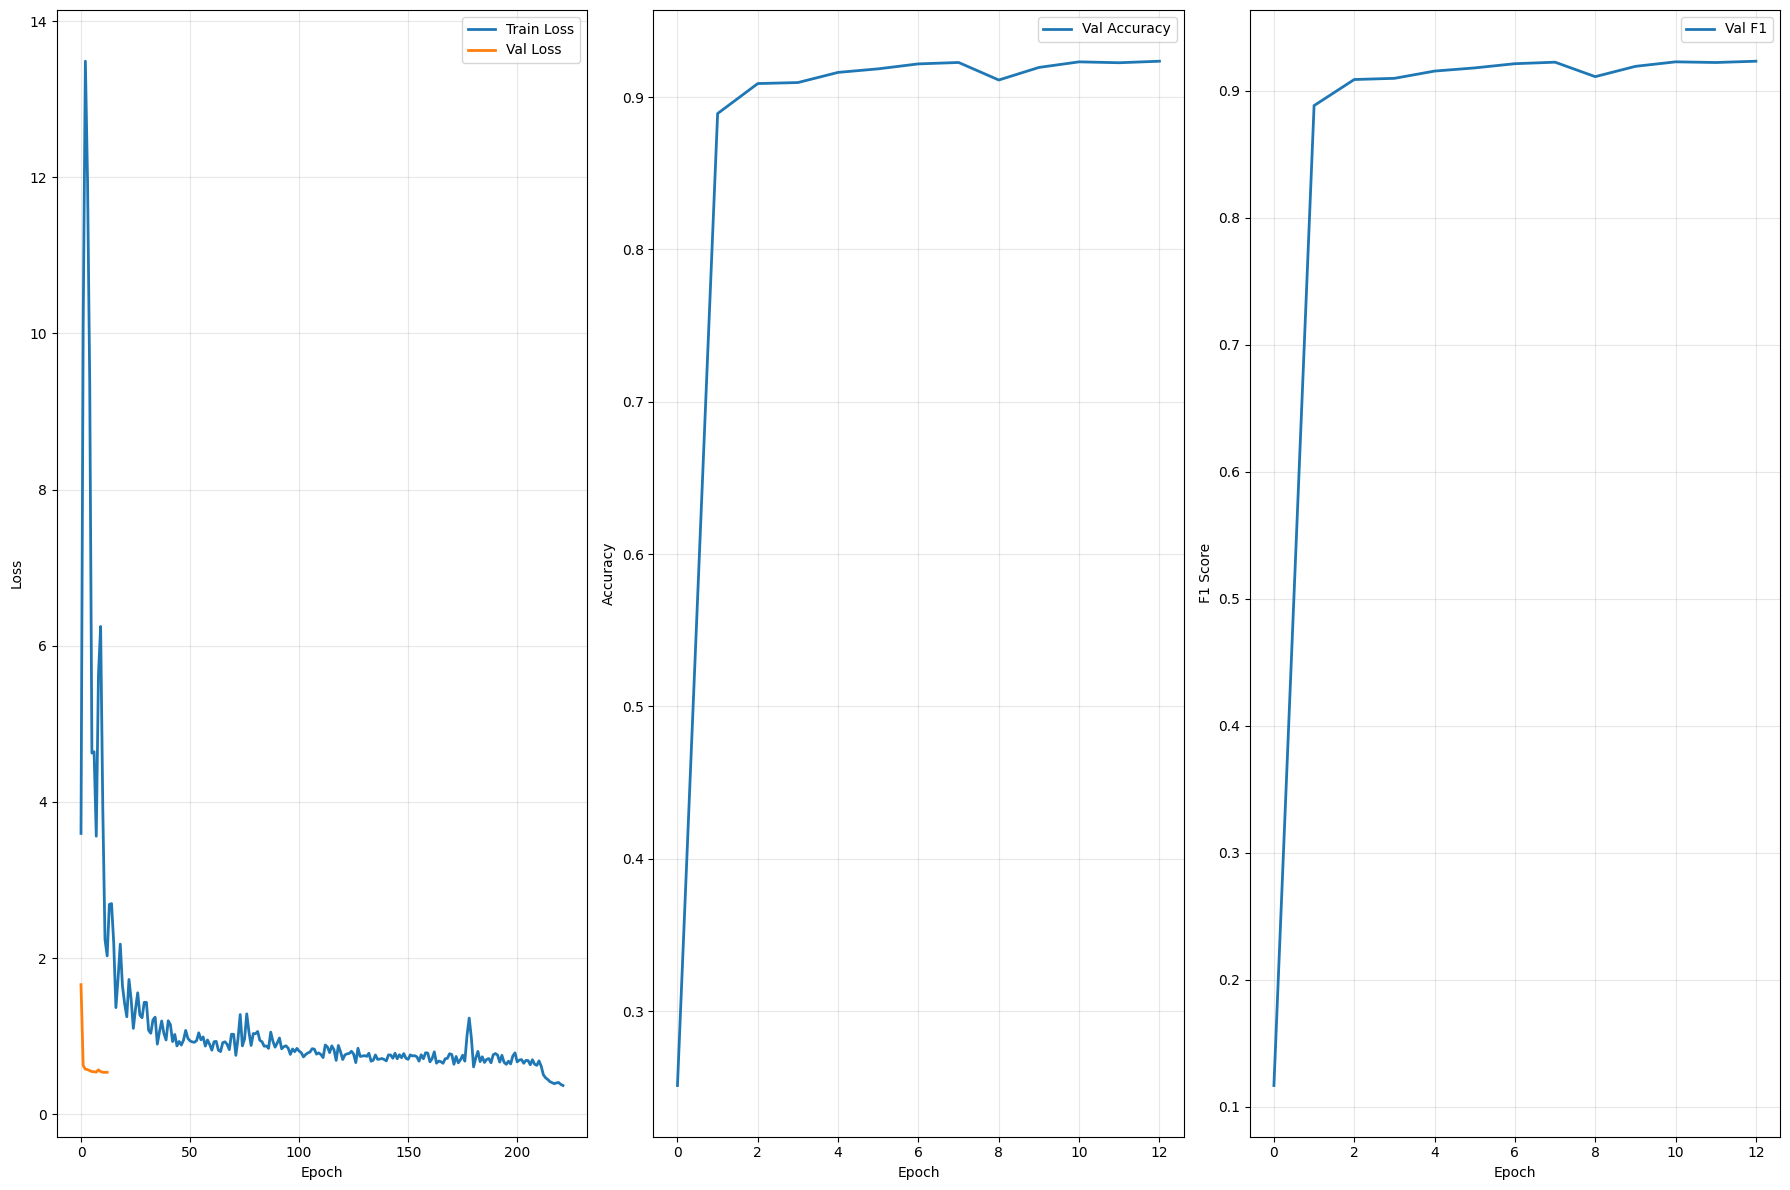

In [34]:
def plot_training_metrics(model_module):
    fig, axes = plt.subplots(1, 3, figsize=(18, 12))

    axes[0].plot(model_module.train_losses, label='Train Loss', linewidth=2)
    axes[0].plot(model_module.val_losses, label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(model_module.val_accs, label='Val Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(model_module.val_f1s, label='Val F1', linewidth=2,)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('metrics_viz.png')
    plt.show()

plot_training_metrics(model)

In [35]:
test_acc = MulticlassAccuracy(num_classes=4)
test_f1 = MulticlassF1Score(num_classes=4, average='macro')

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)

        test_acc(logits, y)
        test_f1(logits, y)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print(f"Test Accuracy: {test_acc.compute().item():.4f}")
print(f"Test Macro F1: {test_f1.compute().item():.4f}")

from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))

Test Accuracy: 0.9213
Test Macro F1: 0.9212
              precision    recall  f1-score   support

       World      0.938     0.907     0.923      1900
      Sports      0.955     0.982     0.968      1900
    Business      0.886     0.895     0.891      1900
    Sci/Tech      0.905     0.901     0.903      1900

    accuracy                          0.921      7600
   macro avg      0.921     0.921     0.921      7600
weighted avg      0.921     0.921     0.921      7600



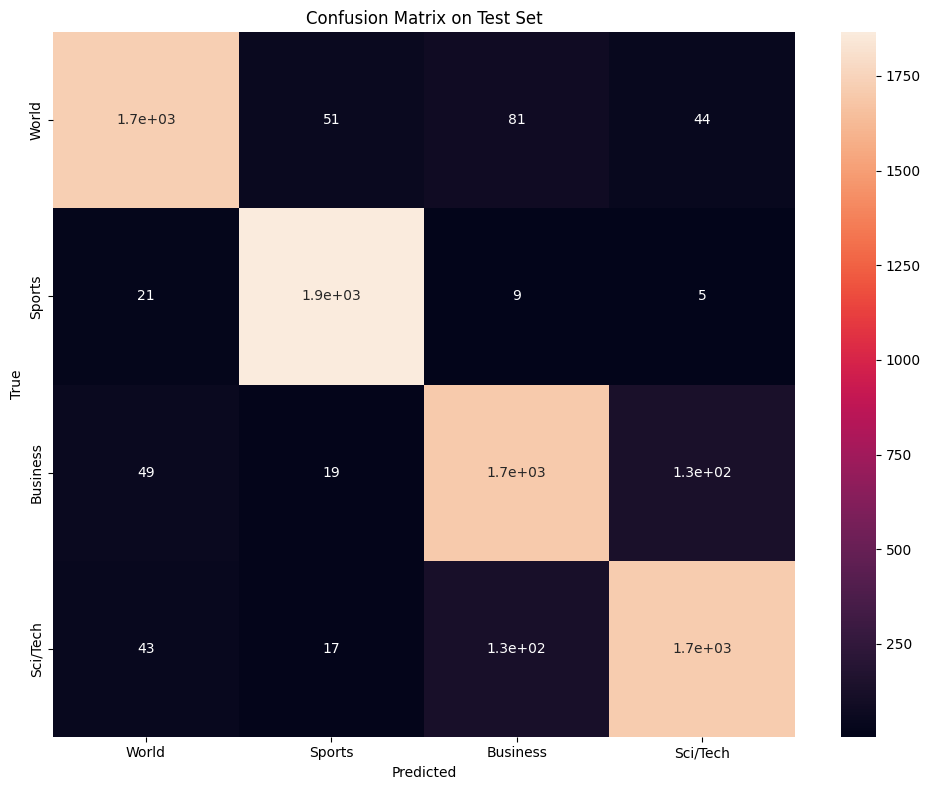

In [36]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()